In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import os
import ast
from analyze_masks import analyze_masks_and_list_exceptions

def categorize_data(data, column):
    """ Categorize the data based on quantiles for a specific column """
    q33 = data[column].quantile(0.33)
    q66 = data[column].quantile(0.66)
    
    category_labels = ["small", "medium", "large"]
    
    conditions = [
        (data[column] <= q33),
        (data[column] > q33) & (data[column] <= q66),
        (data[column] > q66)
    ]
    
    data[f'{column}_category'] = np.select(conditions, category_labels)
    return data

In [2]:
def load_and_process_data(file_path, base_dir, masks_dir, class_to_grayscale_map):
    data = pd.read_csv(file_path)
    confidence_columns = [col for col in data.columns if 'confidence' in col]
    for column in confidence_columns:
        data[column] = data[column].apply(ast.literal_eval)

    data['width'] = 0
    data['height'] = 0
    data['object_percentage'] = 0.0


    for index, row in data.iterrows():
        class_id = row['id'].split('_')[0]
        picture_name = row['picture_name']
        picture_base_name = os.path.splitext(picture_name)[0]

        img_path = os.path.join(base_dir, 'train', class_id, picture_name)
        try:
            with Image.open(img_path) as img:
                width, height = img.size
                data.at[index, 'width'] = width
                data.at[index, 'height'] = height
        except FileNotFoundError:
            print(f"Image not found: {img_path}")

        mask_name = picture_base_name + '.png'
        mask_path = os.path.join(masks_dir, class_id, mask_name)
        try:
            with Image.open(mask_path) as mask:
                mask_array = np.array(mask)
                if class_id in class_to_grayscale_map:
                    relevant_value = class_to_grayscale_map[class_id]
                    print(f"Processing mask for index {index}, class_id {class_id}, relevant_value {relevant_value}")
                    object_pixels = np.sum(mask_array == relevant_value)
                    total_pixels = width * height
                    if total_pixels > 0:
                        data.at[index, 'object_percentage'] = (object_pixels / total_pixels) * 100
                    print(f"object_pixels: {object_pixels}, total_pixels: {total_pixels}, object_percentage: {data.at[index, 'object_percentage']}")
        except FileNotFoundError:
            print(f"Mask not found for image: {mask_path}")

    # Check object_percentage values before categorization
    print(data[['object_percentage']].describe())

    data = categorize_data(data, 'object_percentage')

    return data

In [3]:
def parse_synset_mapping(filepath):
    with open(filepath, 'r') as file:
        class_dict = {}
        for row_number, line in enumerate(file, start=1):
            class_id, description = line.strip().split(' ', 1)
            class_dict[class_id] = {
                "description": description,
                "value": row_number - 1
            }
    return class_dict

In [4]:
class_to_grayscale_map, _ = analyze_masks_and_list_exceptions('../data/masks')

Class: n02412080, Most Common Nonzero Grayscale Value (by presence): 17, Presence Count: 1129
    Images without the most common grayscale value (17): ['n02412080_13145.png', 'n02412080_1976.png', 'n02412080_6399.png', 'n02412080_7812.png', 'n02412080_16811.png', 'n02412080_8153.png', 'n02412080_2188.png', 'n02412080_19324.png', 'n02412080_18733.png', 'n02412080_2270.png', 'n02412080_16830.png', 'n02412080_16254.png', 'n02412080_13623.png', 'n02412080_26458.png', 'n02412080_3944.png', 'n02412080_1040.png', 'n02412080_10804.png', 'n02412080_13818.png', 'n02412080_11852.png', 'n02412080_791.png', 'n02412080_17063.png']
Class: n02107574, Most Common Nonzero Grayscale Value (by presence): 12, Presence Count: 1147
    Images without the most common grayscale value (12): ['n02107574_3660.png', 'n02107574_142.png', 'n02107574_690.png']
Class: n01833805, Most Common Nonzero Grayscale Value (by presence): 3, Presence Count: 1131
    Images without the most common grayscale value (3): ['n0183380

In [7]:
print(f"class_to_grayscale_map: {class_to_grayscale_map}")

class_to_grayscale_map: {'n02412080': 17, 'n02107574': 12, 'n01833805': 3, 'n02124075': 8, 'n02415577': 17, 'n02105641': 12, 'n02123394': 8, 'n01534433': 3, 'n02106662': 12, 'n01558993': 3}


In [5]:
base_dir = '../data'
masks_dir = '../data/masks'
file_path_resnet = '../image_confidence_scores_resnet.csv'
file_path_convnext = '../image_confidence_scores_convnext.csv'
synset_path = '../data/LOC_synset_mapping.txt'

data_resnet = load_and_process_data(file_path_resnet, base_dir, masks_dir, class_to_grayscale_map)
data_convnext = load_and_process_data(file_path_convnext, base_dir, masks_dir, class_to_grayscale_map)
class_dict = parse_synset_mapping(synset_path)

category_distribution_resnet = data_resnet['object_percentage_category'].value_counts()
print(category_distribution_resnet)
print(data_resnet.head())

Processing mask for index 0, class_id n02412080, relevant_value 17
object_pixels: 16834, total_pixels: 187500, object_percentage: 8.978133333333334
Processing mask for index 1, class_id n02412080, relevant_value 17
object_pixels: 58706, total_pixels: 187500, object_percentage: 31.309866666666668
Processing mask for index 2, class_id n02412080, relevant_value 17
object_pixels: 73604, total_pixels: 166500, object_percentage: 44.206606606606606
Processing mask for index 3, class_id n02412080, relevant_value 17
object_pixels: 94807, total_pixels: 177500, object_percentage: 53.41239436619718
Processing mask for index 4, class_id n02412080, relevant_value 17
object_pixels: 38742, total_pixels: 200000, object_percentage: 19.371
Processing mask for index 5, class_id n02412080, relevant_value 17
object_pixels: 23673, total_pixels: 187500, object_percentage: 12.6256
Processing mask for index 6, class_id n02412080, relevant_value 17
object_pixels: 81185, total_pixels: 166500, object_percentage: 4

In [11]:
import pickle

def save_df(df, path):
    with open(path, 'wb') as f:
        pickle.dump(df, f)

def load_df(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

In [10]:
!pwd

/home/paul/Coding/Studies/Magisterka/BackgroundImpactAnalysis/analysis


In [12]:
import os

resnet_results_path = os.path.join('results', 'resnet_df.pkl')
convnext_results_path = os.path.join('results', 'convnext_df.pkl')
save_df(data_resnet, resnet_results_path)
save_df(data_convnext, convnext_results_path)

In [13]:
def parse_synset_mapping(filepath):
    with open(filepath, 'r') as file:
        true_class_dic = {}
        description_dic = {}

        for row_number, line in enumerate(file, start=1):
            class_id, description = line.strip().split(' ', 1)
            true_class_dic[class_id] = str(row_number - 1)
            description_dic[class_id] = str(description)
    return true_class_dic, description_dic

In [14]:
synset_path = '../data/LOC_synset_mapping.txt'

true_class, description = parse_synset_mapping(synset_path)

In [15]:
def add_true_labels(df, true_class):
    true_labels = []
    desc_list = []
    for index, row in df.iterrows():
        class_id = row['id'].split('_')[0]
        true_label = true_class.get(class_id, 'Unknown')
        desc = description.get(class_id, 'Unknown')
        true_labels.append(true_label)
        desc_list.append(desc)
    df['true_label'] = true_labels
    df['true_label_description'] = desc_list
    return df

In [24]:
def process_results(df):
    confidence_columns = [col for col in df.columns if col.endswith('_confidence')]


    for column in df[confidence_columns]:
        predicted_labels = [next(iter(dict(x[0]))) for x in df[column]]
        scores = [next(iter(dict(x[0]).values())) for x in df[column]]
        prefix = column.rpartition('_')[0]
        df[f'{prefix}_score'] = scores
        df[f'{prefix}_prediction'] = predicted_labels
    
    df.drop(columns=confidence_columns, inplace=True)

In [25]:
resnet_df = load_df(resnet_results_path)
convnext_df = load_df(convnext_results_path)

resnet_df = add_true_labels(resnet_df, true_class)
convnext_df = add_true_labels(convnext_df, true_class)

process_results(resnet_df)
process_results(convnext_df)

resnet_df = resnet_df.drop(columns=['width', 'height', 'object_percentage', 'picture_name', 'id'])
convnext_df = convnext_df.drop(columns=['width', 'height', 'object_percentage', 'picture_name', 'id'])

print(resnet_df.shape, convnext_df.shape)
pd.set_option('display.max_columns', None)


(10000, 29) (10000, 29)


In [26]:
resnet_df.head()

object_percentage_category true_label true_label_description  \
0                      small        348               ram, tup   
1                     medium        348               ram, tup   
2                      large        348               ram, tup   
3                      large        348               ram, tup   
4                     medium        348               ram, tup   

   original_score  original_prediction  desert_score  desert_prediction  \
0       58.839279                  349     80.977097                348   
1       75.892090                  348     22.872158                348   
2       81.076469                  348     93.878342                348   
3       53.754341                  348     70.883713                349   
4       89.708168                  349     87.256088                349   

   low_contrast_score  low_contrast_prediction  city_score  city_prediction  \
0           50.551521                      349   69.934639              348   
1           69.402061                      348   88.528374              348   
2           62.501762                      348   58.977772              348   
3           62.867821                      349   50.269855              348   
4           83.907135                      349   83.456581              349   

   sky_score  sky_prediction  jungle_score  jungle_prediction  no_bg_score  \
0  82.987450             348     72.272240                348    59.538448   
1  69.020668             348     65.185081                348    88.840294   
2  94.132629             348     95.790382                348    88.513092   
3  60.222435             349     52.651096                348    69.632660   
4  82.660828             349     65.849808                349    83.180153   

   no_bg_prediction  high_contrast_score  high_contrast_prediction  \
0               349            87.865593                       348   
1               348            86.046425                       348   
2               348            87.129959                       348   
3               349            58.879681                       349   
4               349            77.554497                       349   

   no_foreground_score  no_foreground_prediction  water_score  \
0            29.558765                       240    79.904648   
1            34.195347                       295    51.148842   
2            56.970715                       295    95.263901   
3            11.731533                       649    50.064980   
4            91.065613                       349    67.722954   

   water_prediction  snow_score  snow_prediction  indoor_score  \
0               348   67.014305              349     26.773108   
1               348   80.982758              348     16.747709   
2               348   75.683281              348     89.990028   
3               349   70.590103              349     59.058559   
4               349   88.169632              349     74.471443   

   indoor_prediction  mountain_score  mountain_prediction  
0                453       77.038040                  349  
1                 87       92.803429                  348  
2                348       93.176178                  348  
3                349       68.489357                  349  
4                349       88.701241                  349

In [27]:
convnext_df.head()

object_percentage_category true_label true_label_description  \
0                      small        348               ram, tup   
1                     medium        348               ram, tup   
2                      large        348               ram, tup   
3                      large        348               ram, tup   
4                     medium        348               ram, tup   

   original_score  original_prediction  desert_score  desert_prediction  \
0       46.373386                  349     39.178246                349   
1       78.177628                  348     78.905365                348   
2       79.154984                  348     75.236961                348   
3       40.402241                  348     41.739841                349   
4       49.981297                  349     44.770977                349   

   low_contrast_score  low_contrast_prediction  city_score  city_prediction  \
0           35.915047                      349   36.261684              349   
1           81.804100                      348   85.499680              348   
2           77.332947                      348   73.829636              348   
3           37.637833                      348   39.782448              349   
4           32.670235                      348   42.254787              349   

   sky_score  sky_prediction  jungle_score  jungle_prediction  no_bg_score  \
0  32.841434             348     34.654091                349    37.570412   
1  77.875259             348     84.753433                348    79.177795   
2  77.585464             348     79.860634                348    73.186432   
3  36.871704             348     33.927750                348    38.274361   
4  34.506985             349     33.637314                349    37.412514   

   no_bg_prediction  high_contrast_score  high_contrast_prediction  \
0               349            35.655186                       349   
1               348            80.494812                       348   
2               348            73.709946                       348   
3               349            37.928951                       348   
4               349            33.935677                       349   

   no_foreground_score  no_foreground_prediction  water_score  \
0            32.191479                       348    33.616207   
1            30.929214                       825    81.612816   
2            52.488834                         8    76.116119   
3            30.554974                       295    39.006672   
4            64.156876                       349    35.364922   

   water_prediction  snow_score  snow_prediction  indoor_score  \
0               349   52.296246              349     34.621975   
1               348   81.916199              348     81.708229   
2               348   58.095898              348     73.713272   
3               349   43.786774              349     41.510838   
4               349   44.977673              349     47.262661   

   indoor_prediction  mountain_score  mountain_prediction  
0                349       49.499184                  349  
1                348       85.559204                  348  
2                348       64.670166                  348  
3                349       39.187191                  349  
4                349       44.087524                  349

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_metrics(true_labels, predictions):
    metrics = {
        'accuracy': accuracy_score(true_labels, predictions),
        'precision': precision_score(true_labels, predictions, average='weighted', zero_division=0),
        'recall': recall_score(true_labels, predictions, average='weighted', zero_division=0),
        'f1_score': f1_score(true_labels, predictions, average='weighted', zero_division=0)
    }
    return metrics

In [29]:
def get_original_metrics(df):
    true_labels = df['true_label'].astype(int)
    original_predictions = df['original_prediction'].astype(int)
    return calculate_metrics(true_labels, original_predictions)

In [30]:
def get_modified_metrics(df):
    true_labels = df['true_label'].astype(int)
    modified_predictions = df.filter(like='_prediction').drop(columns=['original_prediction']).astype(int).values.flatten()
    true_labels_repeated = df['true_label'].astype(int).repeat(len(df.filter(like='_prediction').columns) - 1).values
    return calculate_metrics(true_labels_repeated, modified_predictions)

In [32]:
resnet_original_metrics = get_original_metrics(resnet_df)
resnet_modified_metrics = get_modified_metrics(resnet_df)

convnext_original_metrics = get_original_metrics(convnext_df)
convnext_modified_metrics = get_modified_metrics(convnext_df)

results = {
    'Model': ['ResNet', 'ResNet', 'ConvNeXt', 'ConvNeXt'],
    'Type': ['Original', 'Modified', 'Original', 'Modified'],
    'Accuracy': [resnet_original_metrics['accuracy'], resnet_modified_metrics['accuracy'], convnext_original_metrics['accuracy'], convnext_modified_metrics['accuracy']],
    'Precision': [resnet_original_metrics['precision'], resnet_modified_metrics['precision'], convnext_original_metrics['precision'], convnext_modified_metrics['precision']],
    'Recall': [resnet_original_metrics['recall'], resnet_modified_metrics['recall'], convnext_original_metrics['recall'], convnext_modified_metrics['recall']],
    'F1-score': [resnet_original_metrics['f1_score'], resnet_modified_metrics['f1_score'], convnext_original_metrics['f1_score'], convnext_modified_metrics['f1_score']]
}

results_df = pd.DataFrame(results)
print(results_df)
# latex_table = results_df.to_latex(index=False)
#print(latex_table)

      Model      Type  Accuracy  Precision    Recall  F1-score
0    ResNet  Original  0.886500   0.967026  0.886500  0.922742
1    ResNet  Modified  0.702508   0.948506  0.702508  0.806000
2  ConvNeXt  Original  0.943300   0.972519  0.943300  0.956791
3  ConvNeXt  Modified  0.798008   0.961086  0.798008  0.870614


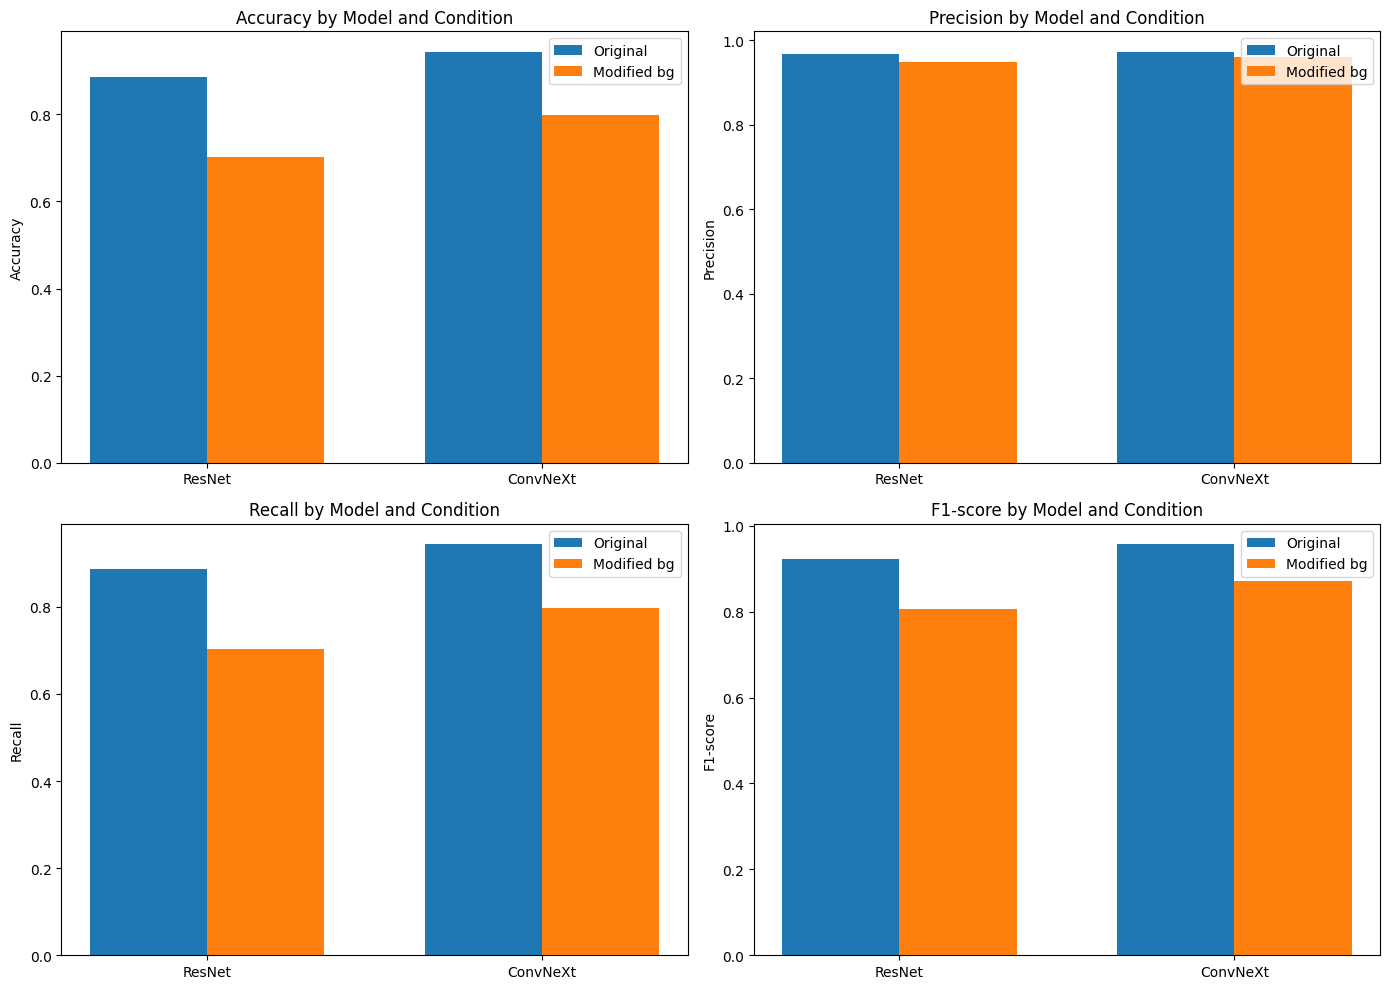

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']

fig, ax = plt.subplots(2, 2, figsize=(14, 10))
x = np.arange(len(results_df['Model'].unique()))
width = 0.35

def create_bar_plot(ax, df, metric_name):
    original = df[df['Type'] == 'Original'][metric_name].values
    modified = df[df['Type'] == 'Modified'][metric_name].values

    rects1 = ax.bar(x - width/2, original, width, label='Original')
    rects2 = ax.bar(x + width/2, modified, width, label='Modified bg')

    ax.set_ylabel(metric_name)
    ax.set_title(f'{metric_name} by Model and Condition')
    ax.set_xticks(x)
    ax.set_xticklabels(df['Model'].unique())
    ax.legend()

for idx, metric in enumerate(metrics):
    create_bar_plot(ax[idx//2, idx%2], results_df, metric)

fig.tight_layout()
plt.show()


In [34]:
def calculate_average_scores(df):
    df['true_label'] = df['true_label'].astype(int)
    df['original_prediction'] = df['original_prediction'].astype(int)
    
    avg_original_score = df['original_score'].mean()

    correct_predictions = df[df['original_prediction'] == df['true_label']]
    avg_correct_score = correct_predictions['original_score'].mean()


    incorrect_predictions = df[df['original_prediction'] != df['true_label']]
    avg_incorrect_score = incorrect_predictions['original_score'].mean()

    return avg_original_score, avg_correct_score, avg_incorrect_score

In [35]:
def calculate_average_scores_all_modifications(df):
    score_columns = [col for col in df.columns if col.endswith('_score') and col != 'original_score']
    prediction_columns = [col for col in df.columns if col.endswith('_prediction') and col != 'original_prediction']
    
    all_scores = []
    correct_scores = []
    incorrect_scores = []

    for score_col, pred_col in zip(score_columns, prediction_columns):
        df['true_label'] = df['true_label'].astype(int)
        df[pred_col] = df[pred_col].astype(int)
        
        all_scores.extend(df[score_col])

        correct_predictions = df[df[pred_col] == df['true_label']]
        correct_scores.extend(correct_predictions[score_col])

        incorrect_predictions = df[df[pred_col] != df['true_label']]
        incorrect_scores.extend(incorrect_predictions[score_col])
    

    avg_all_score = sum(all_scores) / len(all_scores)
    avg_correct_score = sum(correct_scores) / len(correct_scores)
    avg_incorrect_score = sum(incorrect_scores) / len(incorrect_scores)

    return avg_all_score, avg_correct_score, avg_incorrect_score

      Model      Type  Average Score  Average Correct Score  \
0    ResNet  Original      85.188854              89.137424   
1    ResNet  Modified      71.922412              84.054673   
2  ConvNeXt  Original      68.527975              70.036361   
3  ConvNeXt  Modified      57.571384              63.089627   

   Average Incorrect Score  
0                54.348263  
1                43.272820  
2                43.433439  
3                35.770464  


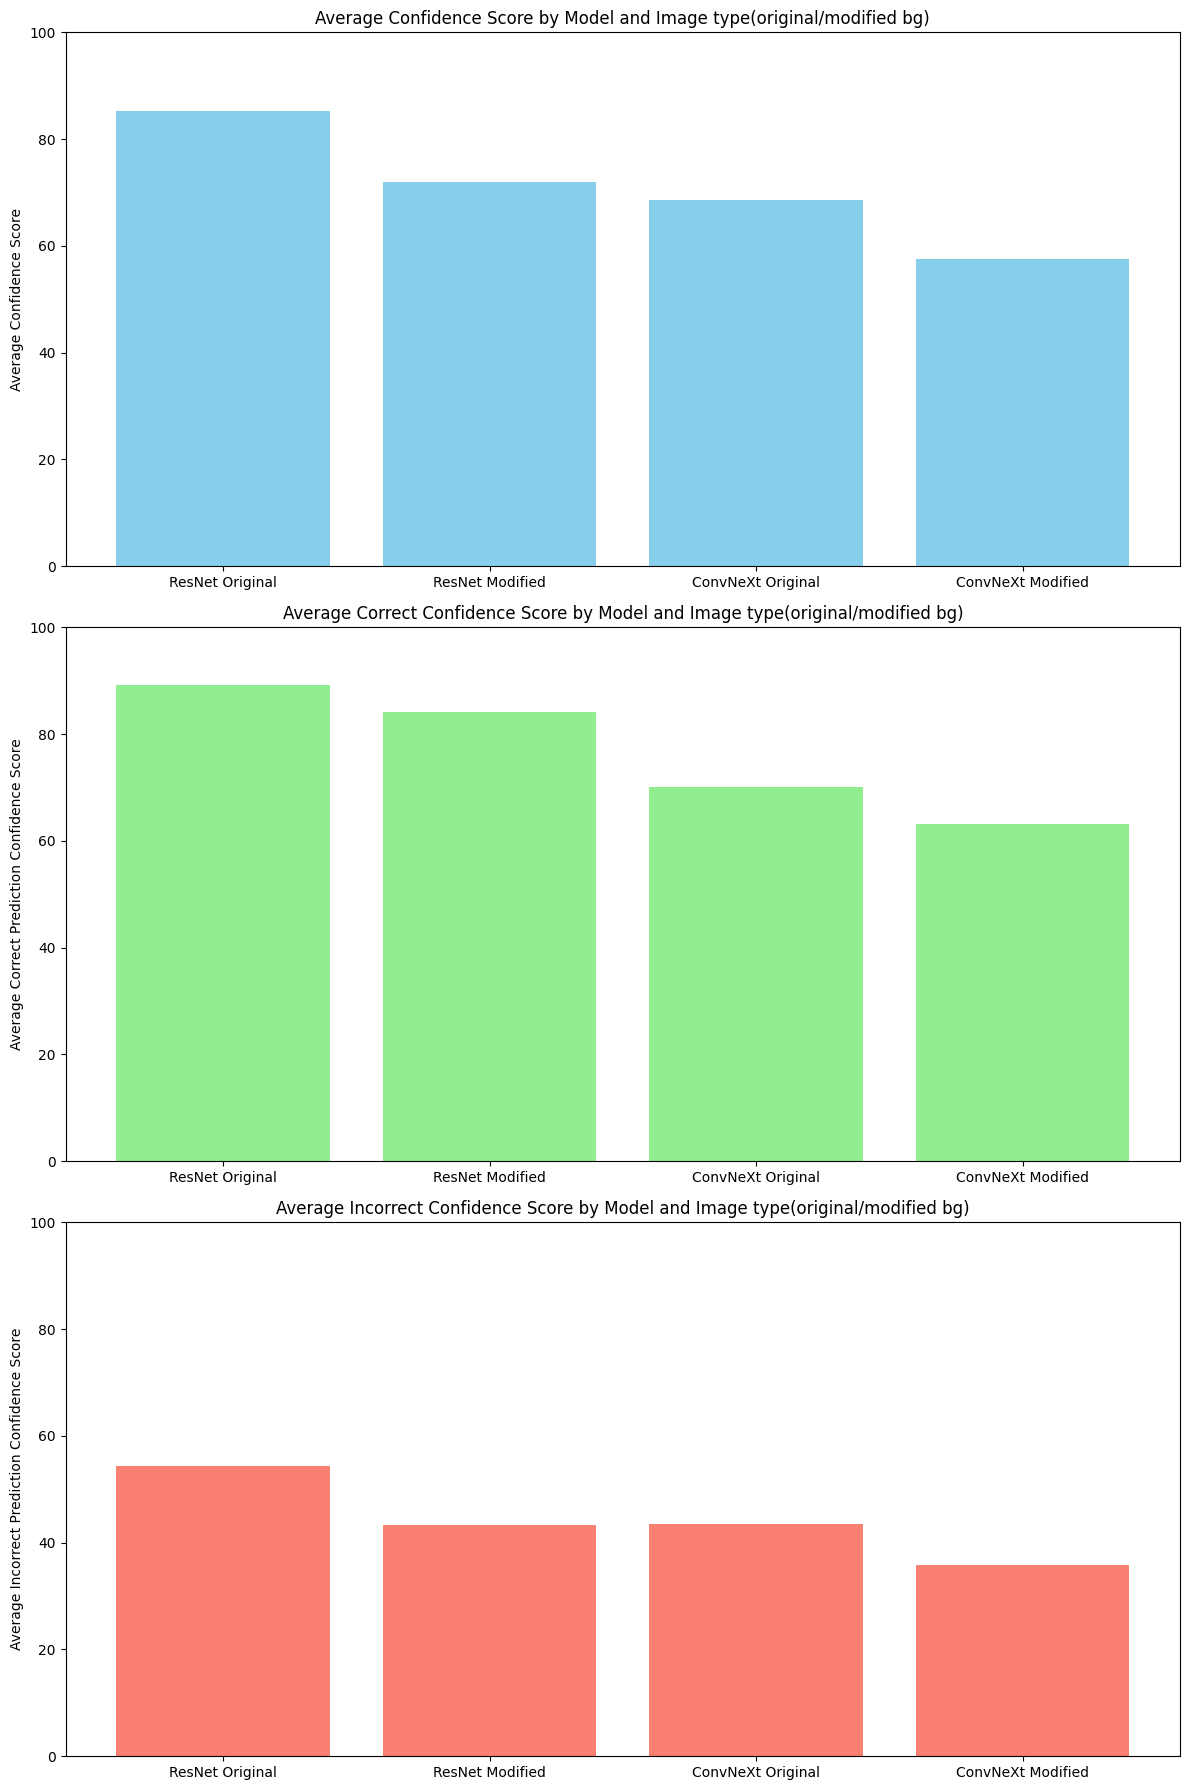

In [36]:
avg_original_resnet, avg_correct_resnet, avg_incorrect_resnet = calculate_average_scores(resnet_df)
avg_mod_resnet, avg_correct_mod_resnet, avg_incorrect_mod_resnet = calculate_average_scores_all_modifications(resnet_df)
avg_original_convnext, avg_correct_convnext, avg_incorrect_convnext = calculate_average_scores(convnext_df)
avg_mod_convnext, avg_correct_mod_convnext, avg_incorrect_mod_convnext = calculate_average_scores_all_modifications(convnext_df)

results_data = {
    'Model': ['ResNet', 'ResNet', 'ConvNeXt', 'ConvNeXt'],
    'Type': ['Original', 'Modified', 'Original', 'Modified'],
    'Average Score': [
        avg_original_resnet, avg_mod_resnet, avg_original_convnext, avg_mod_convnext
    ],
    'Average Correct Score': [
        avg_correct_resnet, avg_correct_mod_resnet, avg_correct_convnext, avg_correct_mod_convnext
    ],
    'Average Incorrect Score': [
        avg_incorrect_resnet, avg_incorrect_mod_resnet, avg_incorrect_convnext, avg_incorrect_mod_convnext
    ]
}

results_df = pd.DataFrame(results_data)
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

axs[0].bar(results_df['Model'] + ' ' + results_df['Type'], results_df['Average Score'], color='skyblue')
axs[0].set_title('Average Confidence Score by Model and Image type(original/modified bg)')
axs[0].set_ylabel('Average Confidence Score')
axs[0].set_ylim(0, 100)

axs[1].bar(results_df['Model'] + ' ' + results_df['Type'], results_df['Average Correct Score'], color='lightgreen')
axs[1].set_title('Average Correct Confidence Score by Model and Image type(original/modified bg)')
axs[1].set_ylabel('Average Correct Prediction Confidence Score')
axs[1].set_ylim(0, 100)

axs[2].bar(results_df['Model'] + ' ' + results_df['Type'], results_df['Average Incorrect Score'], color='salmon')
axs[2].set_title('Average Incorrect Confidence Score by Model and Image type(original/modified bg)')
axs[2].set_ylabel('Average Incorrect Prediction Confidence Score')
axs[2].set_ylim(0, 100)

print(results_df)
plt.tight_layout()
plt.show()

In [37]:
save_df(resnet_df, resnet_results_path)
save_df(convnext_df, convnext_results_path)

In [38]:
resnet_df.head()

object_percentage_category  true_label true_label_description  \
0                      small         348               ram, tup   
1                     medium         348               ram, tup   
2                      large         348               ram, tup   
3                      large         348               ram, tup   
4                     medium         348               ram, tup   

   original_score  original_prediction  desert_score  desert_prediction  \
0       58.839279                  349     80.977097                348   
1       75.892090                  348     22.872158                348   
2       81.076469                  348     93.878342                348   
3       53.754341                  348     70.883713                349   
4       89.708168                  349     87.256088                349   

   low_contrast_score  low_contrast_prediction  city_score  city_prediction  \
0           50.551521                      349   69.934639              348   
1           69.402061                      348   88.528374              348   
2           62.501762                      348   58.977772              348   
3           62.867821                      349   50.269855              348   
4           83.907135                      349   83.456581              349   

   sky_score  sky_prediction  jungle_score  jungle_prediction  no_bg_score  \
0  82.987450             348     72.272240                348    59.538448   
1  69.020668             348     65.185081                348    88.840294   
2  94.132629             348     95.790382                348    88.513092   
3  60.222435             349     52.651096                348    69.632660   
4  82.660828             349     65.849808                349    83.180153   

   no_bg_prediction  high_contrast_score  high_contrast_prediction  \
0               349            87.865593                       348   
1               348            86.046425                       348   
2               348            87.129959                       348   
3               349            58.879681                       349   
4               349            77.554497                       349   

   no_foreground_score  no_foreground_prediction  water_score  \
0            29.558765                       240    79.904648   
1            34.195347                       295    51.148842   
2            56.970715                       295    95.263901   
3            11.731533                       649    50.064980   
4            91.065613                       349    67.722954   

   water_prediction  snow_score  snow_prediction  indoor_score  \
0               348   67.014305              349     26.773108   
1               348   80.982758              348     16.747709   
2               348   75.683281              348     89.990028   
3               349   70.590103              349     59.058559   
4               349   88.169632              349     74.471443   

   indoor_prediction  mountain_score  mountain_prediction  
0                453       77.038040                  349  
1                 87       92.803429                  348  
2                348       93.176178                  348  
3                349       68.489357                  349  
4                349       88.701241                  349

In [39]:
def define_columns(df):
    prediction_columns = [col for col in df.columns if col.endswith('_prediction')]
    confidence_columns = [col for col in df.columns if col.endswith('_score')]
    return prediction_columns, confidence_columns


In [40]:
def correlation_analysis(df, confidence_columns):
    confidence_df = df[confidence_columns]  # Exclude 'object_percentage_category'
    correlations = confidence_df.corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix of Confidence Scores')
    plt.show()

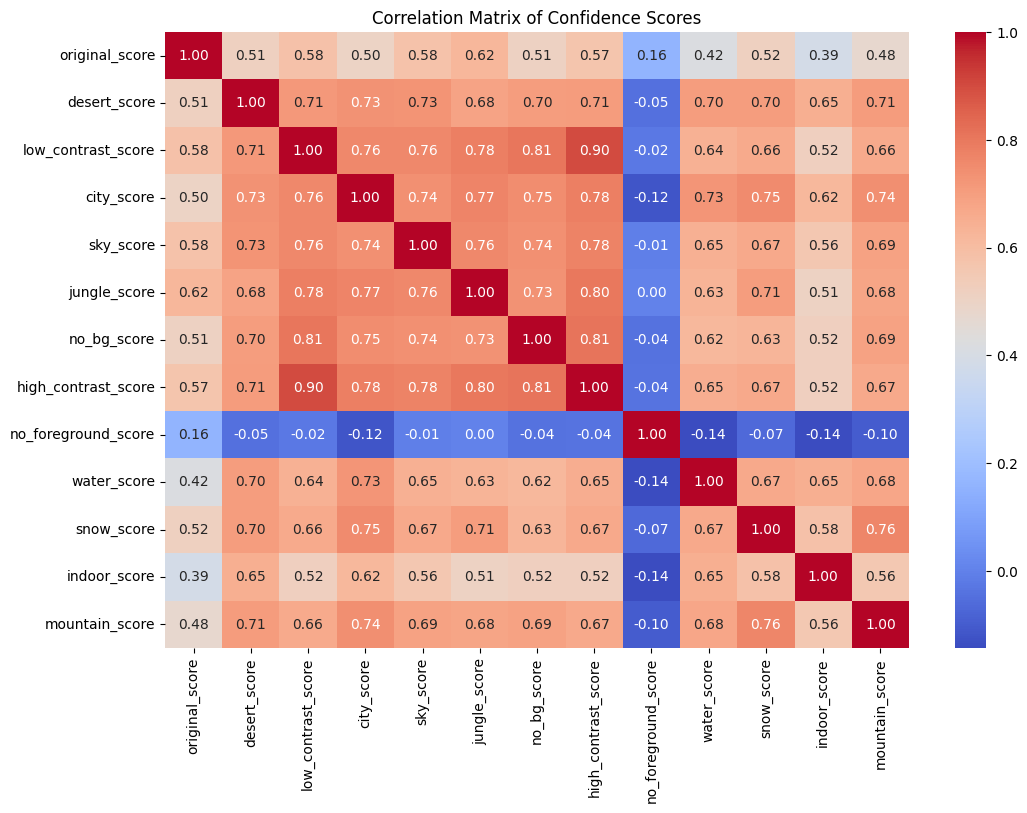

In [41]:
pred, conf = define_columns(resnet_df)
correlation_analysis(resnet_df, conf)

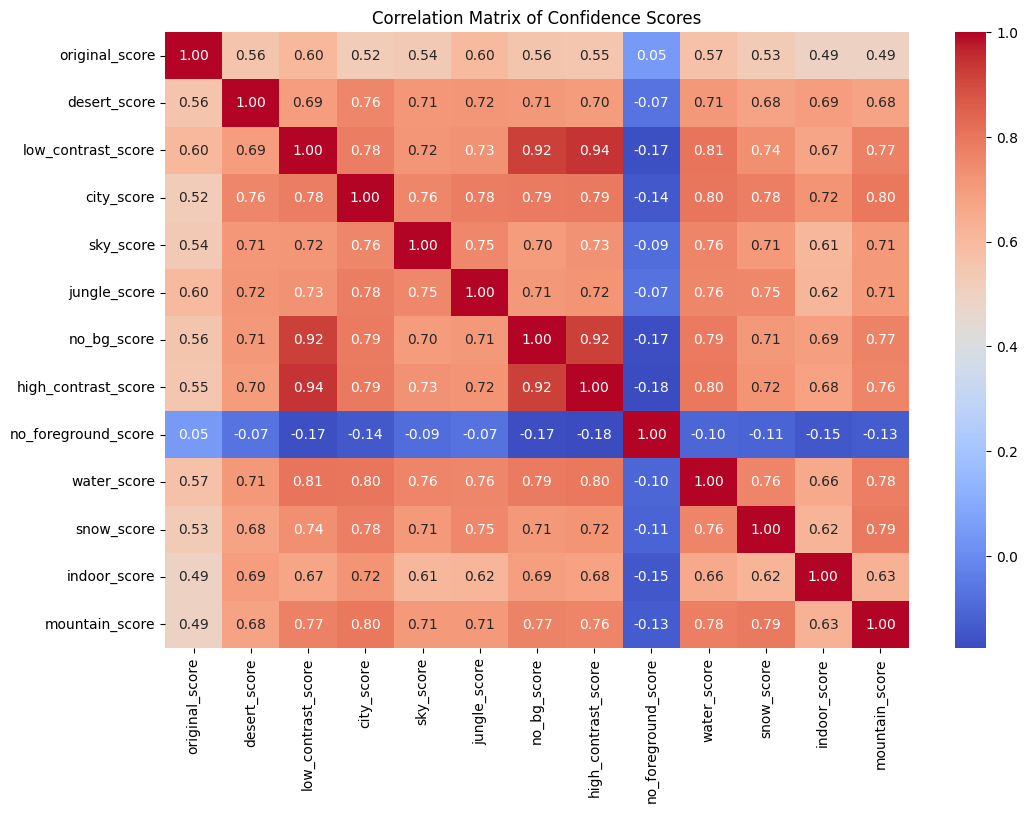

In [42]:
pred, conf = define_columns(convnext_df)
correlation_analysis(convnext_df, conf)

In [43]:
def confidence_score_distribution(df, prediction_columns, confidence_columns):
    df['true_label'] = df['true_label'].astype(int)
    for col in prediction_columns:
        df[col] = df[col].astype(int)

    def is_correct_prediction(row, prediction_col, true_label_col='true_label'):
        return row[true_label_col] == row[prediction_col]

    for pred_col in prediction_columns:
        df[pred_col + '_correct'] = df.apply(lambda row: is_correct_prediction(row, pred_col), axis=1)

    correct_confidences = []
    incorrect_confidences = []

    for score_col, pred_col in zip(confidence_columns, prediction_columns):
        correct_confidences.extend(df[df[pred_col + '_correct']][score_col].dropna().tolist())
        incorrect_confidences.extend(df[~df[pred_col + '_correct']][score_col].dropna().tolist())

    plt.figure(figsize=(12, 6))
    sns.histplot(correct_confidences, color='green', label='Correct Predictions', kde=True, stat="density")
    sns.histplot(incorrect_confidences, color='red', label='Incorrect Predictions', kde=True, stat="density")
    plt.title('Distribution of Confidence Scores for Correct vs Incorrect Predictions')
    plt.xlabel('Confidence Score')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

In [44]:
resnet_df.head()

object_percentage_category  true_label true_label_description  \
0                      small         348               ram, tup   
1                     medium         348               ram, tup   
2                      large         348               ram, tup   
3                      large         348               ram, tup   
4                     medium         348               ram, tup   

   original_score  original_prediction  desert_score  desert_prediction  \
0       58.839279                  349     80.977097                348   
1       75.892090                  348     22.872158                348   
2       81.076469                  348     93.878342                348   
3       53.754341                  348     70.883713                349   
4       89.708168                  349     87.256088                349   

   low_contrast_score  low_contrast_prediction  city_score  city_prediction  \
0           50.551521                      349   69.934639              348   
1           69.402061                      348   88.528374              348   
2           62.501762                      348   58.977772              348   
3           62.867821                      349   50.269855              348   
4           83.907135                      349   83.456581              349   

   sky_score  sky_prediction  jungle_score  jungle_prediction  no_bg_score  \
0  82.987450             348     72.272240                348    59.538448   
1  69.020668             348     65.185081                348    88.840294   
2  94.132629             348     95.790382                348    88.513092   
3  60.222435             349     52.651096                348    69.632660   
4  82.660828             349     65.849808                349    83.180153   

   no_bg_prediction  high_contrast_score  high_contrast_prediction  \
0               349            87.865593                       348   
1               348            86.046425                       348   
2               348            87.129959                       348   
3               349            58.879681                       349   
4               349            77.554497                       349   

   no_foreground_score  no_foreground_prediction  water_score  \
0            29.558765                       240    79.904648   
1            34.195347                       295    51.148842   
2            56.970715                       295    95.263901   
3            11.731533                       649    50.064980   
4            91.065613                       349    67.722954   

   water_prediction  snow_score  snow_prediction  indoor_score  \
0               348   67.014305              349     26.773108   
1               348   80.982758              348     16.747709   
2               348   75.683281              348     89.990028   
3               349   70.590103              349     59.058559   
4               349   88.169632              349     74.471443   

   indoor_prediction  mountain_score  mountain_prediction  
0                453       77.038040                  349  
1                 87       92.803429                  348  
2                348       93.176178                  348  
3                349       68.489357                  349  
4                349       88.701241                  349

In [45]:
convnext_df.head()

object_percentage_category  true_label true_label_description  \
0                      small         348               ram, tup   
1                     medium         348               ram, tup   
2                      large         348               ram, tup   
3                      large         348               ram, tup   
4                     medium         348               ram, tup   

   original_score  original_prediction  desert_score  desert_prediction  \
0       46.373386                  349     39.178246                349   
1       78.177628                  348     78.905365                348   
2       79.154984                  348     75.236961                348   
3       40.402241                  348     41.739841                349   
4       49.981297                  349     44.770977                349   

   low_contrast_score  low_contrast_prediction  city_score  city_prediction  \
0           35.915047                      349   36.261684              349   
1           81.804100                      348   85.499680              348   
2           77.332947                      348   73.829636              348   
3           37.637833                      348   39.782448              349   
4           32.670235                      348   42.254787              349   

   sky_score  sky_prediction  jungle_score  jungle_prediction  no_bg_score  \
0  32.841434             348     34.654091                349    37.570412   
1  77.875259             348     84.753433                348    79.177795   
2  77.585464             348     79.860634                348    73.186432   
3  36.871704             348     33.927750                348    38.274361   
4  34.506985             349     33.637314                349    37.412514   

   no_bg_prediction  high_contrast_score  high_contrast_prediction  \
0               349            35.655186                       349   
1               348            80.494812                       348   
2               348            73.709946                       348   
3               349            37.928951                       348   
4               349            33.935677                       349   

   no_foreground_score  no_foreground_prediction  water_score  \
0            32.191479                       348    33.616207   
1            30.929214                       825    81.612816   
2            52.488834                         8    76.116119   
3            30.554974                       295    39.006672   
4            64.156876                       349    35.364922   

   water_prediction  snow_score  snow_prediction  indoor_score  \
0               349   52.296246              349     34.621975   
1               348   81.916199              348     81.708229   
2               348   58.095898              348     73.713272   
3               349   43.786774              349     41.510838   
4               349   44.977673              349     47.262661   

   indoor_prediction  mountain_score  mountain_prediction  
0                349       49.499184                  349  
1                348       85.559204                  348  
2                348       64.670166                  348  
3                349       39.187191                  349  
4                349       44.087524                  349

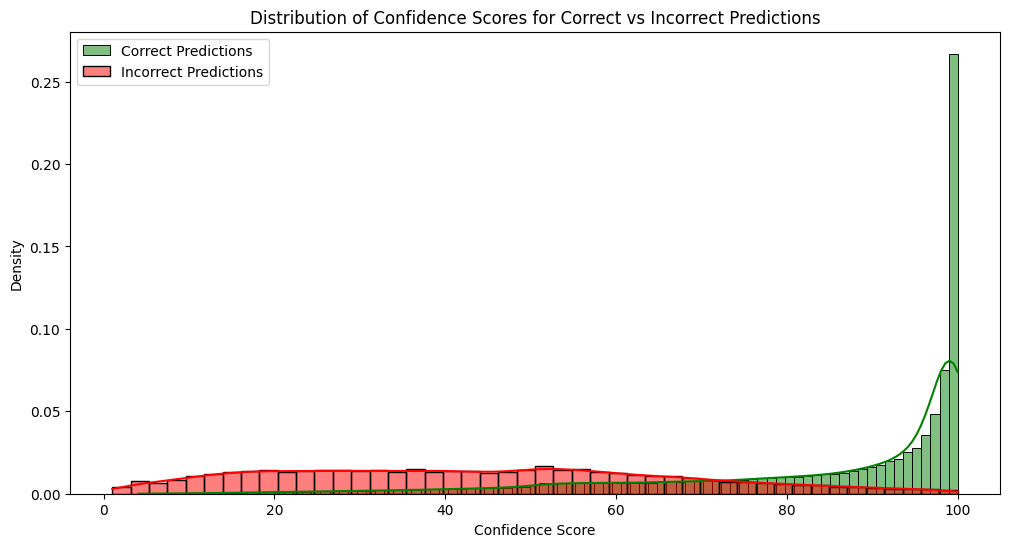

In [46]:
prediction_columns, confidence_columns = define_columns(resnet_df)

confidence_score_distribution(resnet_df, prediction_columns, confidence_columns)

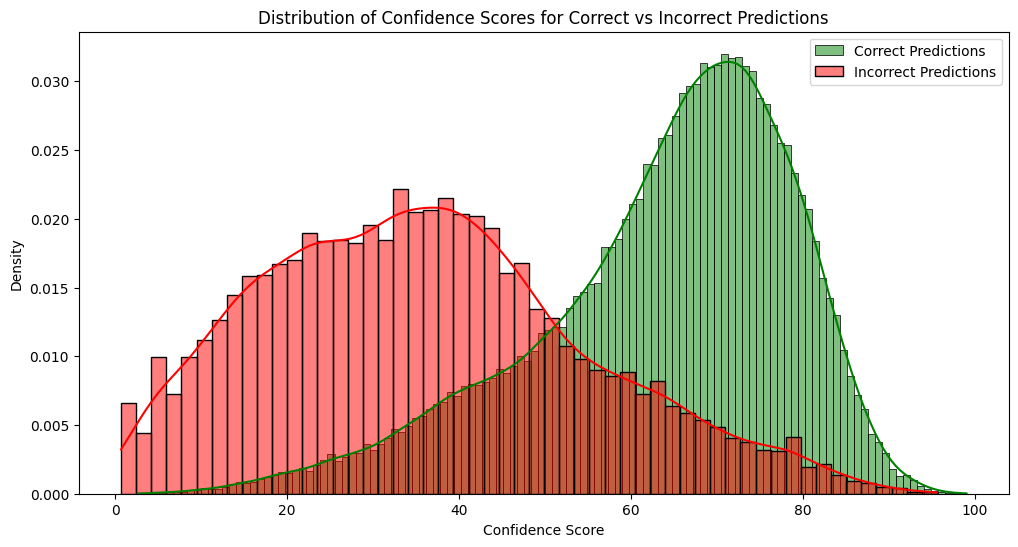

In [47]:
prediction_columns, confidence_columns = define_columns(convnext_df)

confidence_score_distribution(convnext_df, prediction_columns, confidence_columns)

In [48]:
resnet_results_path = os.path.join('results', 'resnet_df.pkl')
convnext_results_path = os.path.join('results', 'convnext_df.pkl')
save_df(resnet_df, resnet_results_path)
save_df(convnext_df, convnext_results_path)

In [49]:
resnet_df = load_df(resnet_results_path)
convnext_df = load_df(convnext_results_path)

In [50]:
resnet_df.head()

object_percentage_category  true_label true_label_description  \
0                      small         348               ram, tup   
1                     medium         348               ram, tup   
2                      large         348               ram, tup   
3                      large         348               ram, tup   
4                     medium         348               ram, tup   

   original_score  original_prediction  desert_score  desert_prediction  \
0       58.839279                  349     80.977097                348   
1       75.892090                  348     22.872158                348   
2       81.076469                  348     93.878342                348   
3       53.754341                  348     70.883713                349   
4       89.708168                  349     87.256088                349   

   low_contrast_score  low_contrast_prediction  city_score  city_prediction  \
0           50.551521                      349   69.934639              348   
1           69.402061                      348   88.528374              348   
2           62.501762                      348   58.977772              348   
3           62.867821                      349   50.269855              348   
4           83.907135                      349   83.456581              349   

   sky_score  sky_prediction  jungle_score  jungle_prediction  no_bg_score  \
0  82.987450             348     72.272240                348    59.538448   
1  69.020668             348     65.185081                348    88.840294   
2  94.132629             348     95.790382                348    88.513092   
3  60.222435             349     52.651096                348    69.632660   
4  82.660828             349     65.849808                349    83.180153   

   no_bg_prediction  high_contrast_score  high_contrast_prediction  \
0               349            87.865593                       348   
1               348            86.046425                       348   
2               348            87.129959                       348   
3               349            58.879681                       349   
4               349            77.554497                       349   

   no_foreground_score  no_foreground_prediction  water_score  \
0            29.558765                       240    79.904648   
1            34.195347                       295    51.148842   
2            56.970715                       295    95.263901   
3            11.731533                       649    50.064980   
4            91.065613                       349    67.722954   

   water_prediction  snow_score  snow_prediction  indoor_score  \
0               348   67.014305              349     26.773108   
1               348   80.982758              348     16.747709   
2               348   75.683281              348     89.990028   
3               349   70.590103              349     59.058559   
4               349   88.169632              349     74.471443   

   indoor_prediction  mountain_score  mountain_prediction  \
0                453       77.038040                  349   
1                 87       92.803429                  348   
2                348       93.176178                  348   
3                349       68.489357                  349   
4                349       88.701241                  349   

   original_prediction_correct  desert_prediction_correct  \
0                        False                       True   
1                         True                       True   
2                         True                       True   
3                         True                      False   
4                        False                      False   

   low_contrast_prediction_correct  city_prediction_correct  \
0                            False                     True   
1                             True                     True   
2                             True                     True   
3        

In [57]:
resnet_df.head()

object_percentage_category  true_label true_label_description  \
0                      small         348               ram, tup   
1                     medium         348               ram, tup   
2                      large         348               ram, tup   
3                      large         348               ram, tup   
4                     medium         348               ram, tup   

   original_score  original_prediction  desert_score  desert_prediction  \
0       58.839279                  349     80.977097                348   
1       75.892090                  348     22.872158                348   
2       81.076469                  348     93.878342                348   
3       53.754341                  348     70.883713                349   
4       89.708168                  349     87.256088                349   

   low_contrast_score  low_contrast_prediction  city_score  city_prediction  \
0           50.551521                      349   69.934639              348   
1           69.402061                      348   88.528374              348   
2           62.501762                      348   58.977772              348   
3           62.867821                      349   50.269855              348   
4           83.907135                      349   83.456581              349   

   sky_score  sky_prediction  jungle_score  jungle_prediction  no_bg_score  \
0  82.987450             348     72.272240                348    59.538448   
1  69.020668             348     65.185081                348    88.840294   
2  94.132629             348     95.790382                348    88.513092   
3  60.222435             349     52.651096                348    69.632660   
4  82.660828             349     65.849808                349    83.180153   

   no_bg_prediction  high_contrast_score  high_contrast_prediction  \
0               349            87.865593                       348   
1               348            86.046425                       348   
2               348            87.129959                       348   
3               349            58.879681                       349   
4               349            77.554497                       349   

   no_foreground_score  no_foreground_prediction  water_score  \
0            29.558765                       240    79.904648   
1            34.195347                       295    51.148842   
2            56.970715                       295    95.263901   
3            11.731533                       649    50.064980   
4            91.065613                       349    67.722954   

   water_prediction  snow_score  snow_prediction  indoor_score  \
0               348   67.014305              349     26.773108   
1               348   80.982758              348     16.747709   
2               348   75.683281              348     89.990028   
3               349   70.590103              349     59.058559   
4               349   88.169632              349     74.471443   

   indoor_prediction  mountain_score  mountain_prediction  \
0                453       77.038040                  349   
1                 87       92.803429                  348   
2                348       93.176178                  348   
3                349       68.489357                  349   
4                349       88.701241                  349   

   original_prediction_correct  desert_prediction_correct  \
0                        False                       True   
1                         True                       True   
2                         True                       True   
3                         True                      False   
4                        False                      False   

   low_contrast_prediction_correct  city_prediction_correct  \
0                            False                     True   
1                             True                     True   
2                             True                     True   
3        

In [58]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_metrics(df, true_label_col, exclude_col, object_size_col):
    metrics = {
        'object_size': [],
        'dataset_type': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': []
    }
    
    modified_predictions_cols = [col for col in df.columns if col.endswith('_prediction') and col != exclude_col]

    grouped = df.groupby(object_size_col)
    
    for name, group in grouped:
        true_labels = group[true_label_col]
        
        original_predictions = group[exclude_col]
        metrics['object_size'].append(name)
        metrics['dataset_type'].append('original')
        metrics['accuracy'].append(accuracy_score(true_labels, original_predictions))
        metrics['precision'].append(precision_score(true_labels, original_predictions, average='weighted', zero_division=0))
        metrics['recall'].append(recall_score(true_labels, original_predictions, average='weighted', zero_division=0))
        metrics['f1_score'].append(f1_score(true_labels, original_predictions, average='weighted', zero_division=0))

        all_modified_predictions = []
        for col in modified_predictions_cols:
            all_modified_predictions.extend(group[col])

        repeated_true_labels = pd.concat([true_labels] * len(modified_predictions_cols)).reset_index(drop=True)

        metrics['object_size'].append(name)
        metrics['dataset_type'].append('modified')
        metrics['accuracy'].append(accuracy_score(repeated_true_labels, all_modified_predictions))
        metrics['precision'].append(precision_score(repeated_true_labels, all_modified_predictions, average='weighted', zero_division=0))
        metrics['recall'].append(recall_score(repeated_true_labels, all_modified_predictions, average='weighted', zero_division=0))
        metrics['f1_score'].append(f1_score(repeated_true_labels, all_modified_predictions, average='weighted', zero_division=0))
    
    return pd.DataFrame(metrics)

In [59]:
metrics_resnet = calculate_metrics(resnet_df, 'true_label', 'original_prediction', 'object_percentage_category')
print(metrics_resnet)

  object_size dataset_type  accuracy  precision    recall  f1_score
0       large     original  0.877353   0.972679  0.877353  0.920111
1       large     modified  0.789338   0.960967  0.789338  0.865607
2      medium     original  0.897879   0.963620  0.897879  0.927600
3      medium     modified  0.762727   0.943926  0.762727  0.841553
4       small     original  0.884545   0.963823  0.884545  0.918217
5       small     modified  0.552828   0.935458  0.552828  0.686206


In [60]:
metrics_convnext = calculate_metrics(convnext_df, 'true_label', 'original_prediction', 'object_percentage_category')
print(metrics_convnext)

  object_size dataset_type  accuracy  precision    recall  f1_score
0       large     original  0.932353   0.974247  0.932353  0.952076
1       large     modified  0.846397   0.970483  0.846397  0.902546
2      medium     original  0.943333   0.970287  0.943333  0.955907
3      medium     modified  0.840682   0.959570  0.840682  0.892625
4       small     original  0.954545   0.972766  0.954545  0.961567
5       small     modified  0.705480   0.950400  0.705480  0.804351


In [61]:
def calculate_confidence_scores(df, object_size_col, true_label_col):
    confidence_columns = [col for col in df.columns if col.endswith('_score')]
    prediction_columns = [col for col in df.columns if col.endswith('_prediction')]

    results = {
        'object_size': [],
        'avg_confidence_score': [],
        'correct_confidence_score': [],
        'incorrect_confidence_score': []
    }

    grouped = df.groupby(object_size_col)

    for name, group in grouped:
        results['object_size'].append(name)

        avg_scores = []
        correct_scores = []
        incorrect_scores = []

        for conf_col, pred_col in zip(confidence_columns, prediction_columns):
            avg_scores.extend(group[conf_col])
            correct_scores.extend(group[conf_col][group[pred_col] == group[true_label_col]])
            incorrect_scores.extend(group[conf_col][group[pred_col] != group[true_label_col]])

        results['avg_confidence_score'].append(np.mean(avg_scores))
        results['correct_confidence_score'].append(np.mean(correct_scores) if correct_scores else 0)
        results['incorrect_confidence_score'].append(np.mean(incorrect_scores) if incorrect_scores else 0)

    return pd.DataFrame(results)


In [62]:
confidence_scores_resnet = calculate_confidence_scores(resnet_df, 'object_percentage_category', 'true_label')

print("Confidence Scores:\n", confidence_scores_resnet)

Confidence Scores:
   object_size  avg_confidence_score  correct_confidence_score  \
0       large             76.790632                 85.228727   
1      medium             76.564846                 85.185492   
2       small             65.356645                 82.693992   

   incorrect_confidence_score  
0                   43.843488  
1                   47.188400  
2                   41.576619  


In [63]:
confidence_scores_convnext = calculate_confidence_scores(convnext_df, 'object_percentage_category', 'true_label')

print("Confidence Scores:\n", confidence_scores_convnext)

Confidence Scores:
   object_size  avg_confidence_score  correct_confidence_score  \
0       large             64.332577                 69.300610   
1      medium             60.275503                 64.107149   
2       small             50.455171                 56.473165   

   incorrect_confidence_score  
0                   35.502391  
1                   38.802715  
2                   34.618265  


In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def detect_modification_types(df):
    prediction_columns = [col for col in df.columns if col.endswith('_prediction') and col != 'original_prediction']
    modification_types = [col.replace('_prediction', '') for col in prediction_columns]
    return modification_types

In [66]:
def calculate_metrics_and_confidence_by_modification(df, true_label_col):
    modification_types = detect_modification_types(df)
    
    results = {
        'modification_type': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': [],
        'avg_confidence_score': [],
        'correct_confidence_score': [],
        'incorrect_confidence_score': []
    }

    for mod_type in modification_types:
        pred_col = f'{mod_type}_prediction'
        score_col = f'{mod_type}_score'

        accuracy = accuracy_score(df[true_label_col], df[pred_col])
        precision = precision_score(df[true_label_col], df[pred_col], average='weighted', zero_division=0)
        recall = recall_score(df[true_label_col], df[pred_col], average='weighted', zero_division=0)
        f1 = f1_score(df[true_label_col], df[pred_col], average='weighted', zero_division=0)
        
        avg_confidence = np.mean(df[score_col])
        correct_confidence = np.mean(df[score_col][df[pred_col] == df[true_label_col]])
        incorrect_confidence = np.mean(df[score_col][df[pred_col] != df[true_label_col]])

        results['modification_type'].append(mod_type)
        results['accuracy'].append(accuracy)
        results['precision'].append(precision)
        results['recall'].append(recall)
        results['f1_score'].append(f1)
        results['avg_confidence_score'].append(avg_confidence)
        results['correct_confidence_score'].append(correct_confidence)
        results['incorrect_confidence_score'].append(incorrect_confidence)

    return pd.DataFrame(results)

In [67]:
def plot_correlation_matrix(df):
    corr = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()

In [68]:

def calculate_accuracy_per_image(df, true_label_col):
    """
    Calculates accuracy for each image and each modification type.

    Parameters:
    df (pd.DataFrame): DataFrame containing true labels and predictions
    true_label_col (str): Column name for true labels

    Returns:
    pd.DataFrame: DataFrame with accuracy per image for each modification type
    """
    modification_types = detect_modification_types(df)
    
    results = {
        'image_id': df.index
    }
    
    for mod_type in modification_types:
        pred_col = f'{mod_type}_prediction'
        accuracy_col = f'{mod_type}_accuracy'
        
        results[accuracy_col] = df.apply(lambda row: 1 if row[true_label_col] == row[pred_col] else 0, axis=1)

    return pd.DataFrame(results)

Metrics and Confidence Scores by Modification Type:
    modification_type  accuracy  precision  recall  f1_score  \
0             desert    0.7582   0.956658  0.7582  0.844717   
1       low_contrast    0.7835   0.957333  0.7835  0.859445   
2               city    0.7620   0.955729  0.7620  0.845955   
3                sky    0.7577   0.951998  0.7577  0.840614   
4             jungle    0.7736   0.952716  0.7736  0.846911   
5              no_bg    0.7629   0.948944  0.7629  0.843935   
6      high_contrast    0.7757   0.952540  0.7757  0.852606   
7      no_foreground    0.1935   0.857598  0.1935  0.260654   
8              water    0.7198   0.950886  0.7198  0.812003   
9               snow    0.7462   0.961568  0.7462  0.833842   
10            indoor    0.6990   0.950477  0.6990  0.801644   
11          mountain    0.6980   0.959372  0.6980  0.800749   

    avg_confidence_score  correct_confidence_score  incorrect_confidence_score  
0              75.954396                 84.30

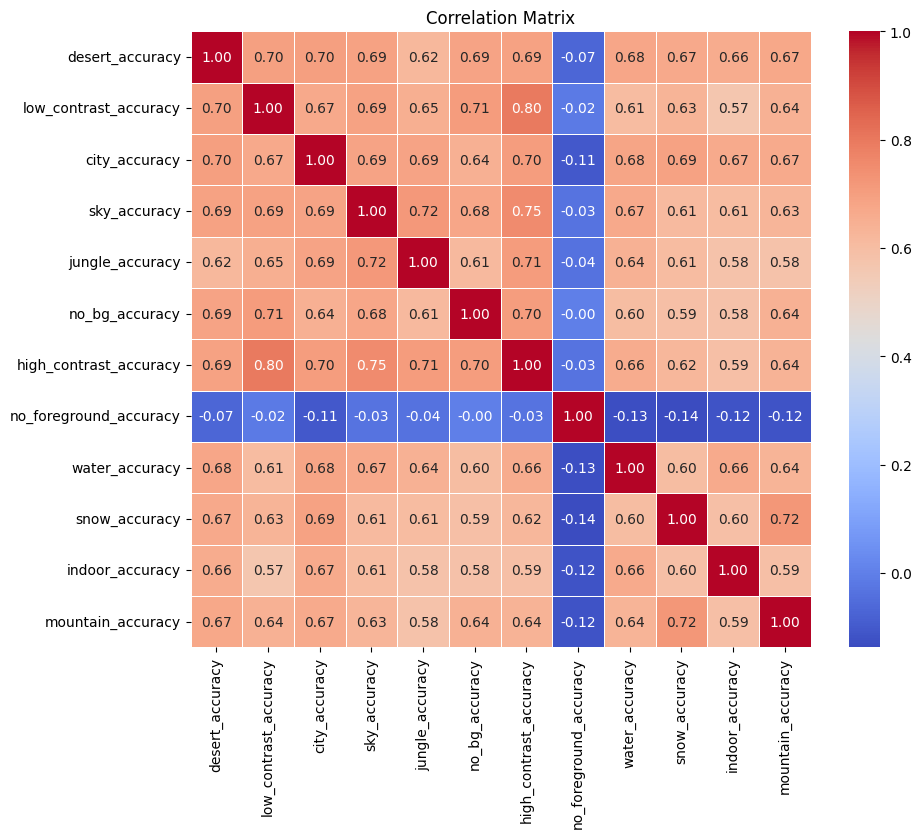

In [69]:

metrics_confidence_df = calculate_metrics_and_confidence_by_modification(resnet_df, 'true_label')

print("Metrics and Confidence Scores by Modification Type:\n", metrics_confidence_df)

accuracy_per_image_df = calculate_accuracy_per_image(resnet_df, 'true_label')

accuracy_per_image_df = accuracy_per_image_df.drop(columns=['image_id'])

print("Accuracy per Image DataFrame:\n", accuracy_per_image_df)

plot_correlation_matrix(accuracy_per_image_df)


Metrics and Confidence Scores by Modification Type:
    modification_type  accuracy  precision  recall  f1_score  \
0             desert    0.8234   0.965246  0.8234  0.885689   
1       low_contrast    0.8897   0.965665  0.8897  0.925404   
2               city    0.8392   0.967133  0.8392  0.894941   
3                sky    0.8259   0.958754  0.8259  0.886533   
4             jungle    0.8621   0.963912  0.8621  0.909624   
5              no_bg    0.8765   0.961364  0.8765  0.915996   
6      high_contrast    0.8707   0.964345  0.8707  0.913518   
7      no_foreground    0.2572   0.921080  0.2572  0.343413   
8              water    0.8593   0.960770  0.8593  0.906849   
9               snow    0.8567   0.966667  0.8567  0.902537   
10            indoor    0.7797   0.965780  0.7797  0.859119   
11          mountain    0.8357   0.964700  0.8357  0.891118   

    avg_confidence_score  correct_confidence_score  incorrect_confidence_score  
0              61.750625                 65.26

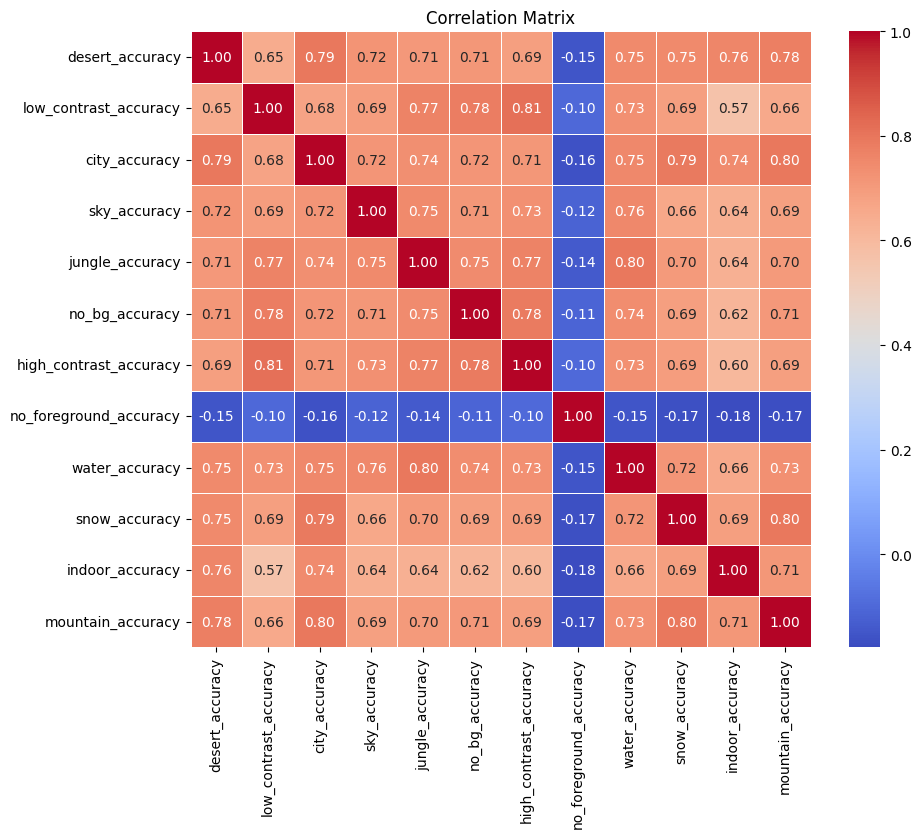

In [70]:

metrics_confidence_df = calculate_metrics_and_confidence_by_modification(convnext_df, 'true_label')

print("Metrics and Confidence Scores by Modification Type:\n", metrics_confidence_df)

accuracy_per_image_df = calculate_accuracy_per_image(convnext_df, 'true_label')

accuracy_per_image_df = accuracy_per_image_df.drop(columns=['image_id'])

print("Accuracy per Image DataFrame:\n", accuracy_per_image_df)

plot_correlation_matrix(accuracy_per_image_df)

In [71]:
def parse_synset_mapping(filepath):
    with open(filepath, 'r') as file:
        true_class_dic = {}
        description_dic = {}

        for row_number, line in enumerate(file, start=1):
            class_id, description = line.strip().split(' ', 1)
            true_class_dic[class_id] = str(row_number - 1)
            description_dic[class_id] = str(description)
    return true_class_dic, description_dic

def create_reverse_mapping(true_class_dic):
    reverse_mapping = {int(v): k for k, v in true_class_dic.items()}
    return reverse_mapping

def shorten_description(description):
    parts = description.split(',')
    if len(parts) > 2:
        return ','.join(parts[:2])
    return description

In [73]:
def analyze_class(df1, df2, true_label, true_label_col='true_label', synset_path='../data/LOC_synset_mapping.txt'):
    if synset_path is None:
        raise ValueError("synset_path must be provided")
    
    true_class_dic, description = parse_synset_mapping(synset_path)
    reverse_mapping = create_reverse_mapping(true_class_dic)

    modification_types_1 = detect_modification_types(df1)
    modification_types_2 = detect_modification_types(df2)
    
    results = {
        'modification_type': [],
        'accuracy_resnet': [],
        'avg_confidence_resnet': [],
        'most_mistaken_for_resnet': [],
        'accuracy_convnext': [],
        'avg_confidence_convnext': [],
        'most_mistaken_for_convnext': []
    }

    class_df1 = df1[df1[true_label_col] == true_label]
    class_df2 = df2[df2[true_label_col] == true_label]

    def get_description(label):
        class_identifier = reverse_mapping.get(label, str(label))
        return shorten_description(description.get(class_identifier, str(label)))

    # Include original images analysis
    for mod_type in ['original'] + modification_types_1:
        pred_col = f'{mod_type}_prediction'
        score_col = f'{mod_type}_score'

        accuracy_1 = accuracy_score(class_df1[true_label_col], class_df1[pred_col])
        avg_confidence_1 = np.mean(class_df1[score_col])
        mistaken_classes_1 = class_df1[class_df1[pred_col] != true_label][pred_col]
        if not mistaken_classes_1.empty:
            most_mistaken_for_1 = mistaken_classes_1.value_counts().idxmax()
            mistake_count_1 = mistaken_classes_1.value_counts().max()
            most_mistaken_for_1_description = f"{get_description(most_mistaken_for_1)} ({mistake_count_1})"
        else:
            most_mistaken_for_1_description = None

        results['modification_type'].append(mod_type)
        results['accuracy_resnet'].append(accuracy_1)
        results['avg_confidence_resnet'].append(avg_confidence_1)
        results['most_mistaken_for_resnet'].append(most_mistaken_for_1_description)

    for mod_type in ['original'] + modification_types_2:
        pred_col = f'{mod_type}_prediction'
        score_col = f'{mod_type}_score'

        accuracy_2 = accuracy_score(class_df2[true_label_col], class_df2[pred_col])
        avg_confidence_2 = np.mean(class_df2[score_col])
        mistaken_classes_2 = class_df2[class_df2[pred_col] != true_label][pred_col]
        if not mistaken_classes_2.empty:
            most_mistaken_for_2 = mistaken_classes_2.value_counts().idxmax()
            mistake_count_2 = mistaken_classes_2.value_counts().max()
            most_mistaken_for_2_description = f"{get_description(most_mistaken_for_2)} ({mistake_count_2})"
        else:
            most_mistaken_for_2_description = None

        results['accuracy_convnext'].append(accuracy_2)
        results['avg_confidence_convnext'].append(avg_confidence_2)
        results['most_mistaken_for_convnext'].append(most_mistaken_for_2_description)

    return pd.DataFrame(results)

In [74]:
print(resnet_df['true_label'].unique())
print(resnet_df['true_label_description'].unique())

[348 238  94 285 349 229 283  13 235  15]
['ram, tup' 'Greater Swiss Mountain dog' 'hummingbird' 'Egyptian cat'
 'bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis'
 'Old English sheepdog, bobtail' 'Persian cat' 'junco, snowbird'
 'German shepherd, German shepherd dog, German police dog, alsatian'
 'robin, American robin, Turdus migratorius']


In [75]:
class_analysis_df = analyze_class(resnet_df, convnext_df, 348)
print(f"Metrics and Confidence Scores for class {348} (ram, tup):\n", class_analysis_df)

Metrics and Confidence Scores for class 348 (ram, tup):
    modification_type  accuracy_resnet  avg_confidence_resnet  \
0           original            0.781              80.888742   
1             desert            0.662              73.618091   
2       low_contrast            0.637              72.533478   
3               city            0.691              71.055787   
4                sky            0.752              74.196770   
5             jungle            0.825              76.201070   
6              no_bg            0.668              71.519892   
7      high_contrast            0.735              73.587178   
8      no_foreground            0.136              38.340821   
9              water            0.780              72.729140   
10              snow            0.601              76.547279   
11            indoor            0.683              71.596914   
12          mountain            0.613              74.327448   

                 most_mistaken_for_resnet  acc

In [76]:
class_analysis_df = analyze_class(resnet_df, convnext_df, 238)
print(f"Metrics and Confidence Scores for class {238} (Greater Swiss Mountain dog):\n", class_analysis_df)

Metrics and Confidence Scores for class 238 (Greater Swiss Mountain dog):
    modification_type  accuracy_resnet  avg_confidence_resnet  \
0           original            0.746              69.254460   
1             desert            0.751              71.670600   
2       low_contrast            0.628              66.772043   
3               city            0.720              70.455594   
4                sky            0.693              67.656871   
5             jungle            0.680              66.612556   
6              no_bg            0.675              66.545953   
7      high_contrast            0.632              65.697515   
8      no_foreground            0.009              29.458587   
9              water            0.679              65.613398   
10              snow            0.748              71.034704   
11            indoor            0.750              71.739733   
12          mountain            0.605              63.748537   

                most_mistake

In [77]:
class_analysis_df = analyze_class(resnet_df, convnext_df, 94)
print(f"Metrics and Confidence Scores for class {94} (Hummingbird):\n", class_analysis_df)

Metrics and Confidence Scores for class 94 (Hummingbird):
    modification_type  accuracy_resnet  avg_confidence_resnet  \
0           original            0.963              95.023629   
1             desert            0.677              73.851502   
2       low_contrast            0.836              83.892216   
3               city            0.649              63.584482   
4                sky            0.789              81.238139   
5             jungle            0.796              80.272471   
6              no_bg            0.816              80.511866   
7      high_contrast            0.782              79.808579   
8      no_foreground            0.744              69.953177   
9              water            0.525              60.158964   
10              snow            0.543              63.296984   
11            indoor            0.565              66.628743   
12          mountain            0.456              54.866228   

      most_mistaken_for_resnet  accuracy_con

In [78]:
class_analysis_df = analyze_class(resnet_df, convnext_df, 285)
print(f"Metrics and Confidence Scores for class {285} (Egyptian cat):\n", class_analysis_df)

Metrics and Confidence Scores for class 285 (Egyptian cat):
    modification_type  accuracy_resnet  avg_confidence_resnet  \
0           original            0.782              73.471966   
1             desert            0.825              76.229713   
2       low_contrast            0.821              78.051673   
3               city            0.763              71.972776   
4                sky            0.766              71.577528   
5             jungle            0.698              70.001732   
6              no_bg            0.847              76.844117   
7      high_contrast            0.794              77.981898   
8      no_foreground            0.260              33.898078   
9              water            0.846              75.972695   
10              snow            0.647              67.339146   
11            indoor            0.743              74.809806   
12          mountain            0.730              67.302426   

   most_mistaken_for_resnet  accuracy_conv

In [79]:
print(resnet_df['true_label'].unique())
print(resnet_df['true_label_description'].unique())
class_analysis_df = analyze_class(resnet_df, convnext_df, 349)
print(f"Metrics and Confidence Scores for class {349} (Bighorn sheep):\n", class_analysis_df)

[348 238  94 285 349 229 283  13 235  15]
['ram, tup' 'Greater Swiss Mountain dog' 'hummingbird' 'Egyptian cat'
 'bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis'
 'Old English sheepdog, bobtail' 'Persian cat' 'junco, snowbird'
 'German shepherd, German shepherd dog, German police dog, alsatian'
 'robin, American robin, Turdus migratorius']
Metrics and Confidence Scores for class 349 (Bighorn sheep):
    modification_type  accuracy_resnet  avg_confidence_resnet  \
0           original            0.857              76.879462   
1             desert            0.644              65.576020   
2       low_contrast            0.707              62.688885   
3               city            0.583              57.522109   
4                sky            0.501              61.268969   
5             jungle            0.471              59.756806   
6              no_bg            0.635              57.550804   
7      high_contrast            0.5

In [80]:
print(resnet_df['true_label'].unique())
print(resnet_df['true_label_description'].unique())
class_analysis_df = analyze_class(resnet_df, convnext_df, 229)
print(f"Metrics and Confidence Scores for class {229} (Old English sheepdog):\n", class_analysis_df)

[348 238  94 285 349 229 283  13 235  15]
['ram, tup' 'Greater Swiss Mountain dog' 'hummingbird' 'Egyptian cat'
 'bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis'
 'Old English sheepdog, bobtail' 'Persian cat' 'junco, snowbird'
 'German shepherd, German shepherd dog, German police dog, alsatian'
 'robin, American robin, Turdus migratorius']
Metrics and Confidence Scores for class 229 (Old English sheepdog):
    modification_type  accuracy_resnet  avg_confidence_resnet  \
0           original            0.941              88.632230   
1             desert            0.801              80.359347   
2       low_contrast            0.785              77.904651   
3               city            0.765              74.680369   
4                sky            0.718              74.347288   
5             jungle            0.782              75.977385   
6              no_bg            0.709              71.070938   
7      high_contrast        

In [81]:
print(resnet_df['true_label'].unique())
print(resnet_df['true_label_description'].unique())
class_analysis_df = analyze_class(resnet_df, convnext_df, 283)
print(f"Metrics and Confidence Scores for class {283} (Persian cat):\n", class_analysis_df)

[348 238  94 285 349 229 283  13 235  15]
['ram, tup' 'Greater Swiss Mountain dog' 'hummingbird' 'Egyptian cat'
 'bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis'
 'Old English sheepdog, bobtail' 'Persian cat' 'junco, snowbird'
 'German shepherd, German shepherd dog, German police dog, alsatian'
 'robin, American robin, Turdus migratorius']
Metrics and Confidence Scores for class 283 (Persian cat):
    modification_type  accuracy_resnet  avg_confidence_resnet  \
0           original            0.964              93.028729   
1             desert            0.848              83.349976   
2       low_contrast            0.855              83.713232   
3               city            0.877              84.163735   
4                sky            0.821              82.203083   
5             jungle            0.831              81.888781   
6              no_bg            0.844              81.940165   
7      high_contrast            0.853

In [82]:
print(resnet_df['true_label'].unique())
print(resnet_df['true_label_description'].unique())
class_analysis_df = analyze_class(resnet_df, convnext_df, 13)
print(f"Metrics and Confidence Scores for class {13} (junco, snowbird):\n", class_analysis_df)

[348 238  94 285 349 229 283  13 235  15]
['ram, tup' 'Greater Swiss Mountain dog' 'hummingbird' 'Egyptian cat'
 'bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis'
 'Old English sheepdog, bobtail' 'Persian cat' 'junco, snowbird'
 'German shepherd, German shepherd dog, German police dog, alsatian'
 'robin, American robin, Turdus migratorius']
Metrics and Confidence Scores for class 13 (junco, snowbird):
    modification_type  accuracy_resnet  avg_confidence_resnet  \
0           original            0.976              95.314826   
1             desert            0.839              81.161059   
2       low_contrast            0.877              86.390556   
3               city            0.842              75.437180   
4                sky            0.842              83.426079   
5             jungle            0.920              90.342285   
6              no_bg            0.858              84.076516   
7      high_contrast            0.

In [83]:
print(resnet_df['true_label'].unique())
print(resnet_df['true_label_description'].unique())
class_analysis_df = analyze_class(resnet_df, convnext_df, 235)
print(f"Metrics and Confidence Scores for class {235} (German shepherd):\n", class_analysis_df)

[348 238  94 285 349 229 283  13 235  15]
['ram, tup' 'Greater Swiss Mountain dog' 'hummingbird' 'Egyptian cat'
 'bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis'
 'Old English sheepdog, bobtail' 'Persian cat' 'junco, snowbird'
 'German shepherd, German shepherd dog, German police dog, alsatian'
 'robin, American robin, Turdus migratorius']
Metrics and Confidence Scores for class 235 (German shepherd):
    modification_type  accuracy_resnet  avg_confidence_resnet  \
0           original            0.874              82.761220   
1             desert            0.705              72.608107   
2       low_contrast            0.806              77.606469   
3               city            0.821              77.924239   
4                sky            0.787              75.390463   
5             jungle            0.788              76.892591   
6              no_bg            0.705              67.817178   
7      high_contrast            0

In [84]:
print(resnet_df['true_label'].unique())
print(resnet_df['true_label_description'].unique())
class_analysis_df = analyze_class(resnet_df, convnext_df, 15)
print(f"Metrics and Confidence Scores for class {15} (American robin):\n", class_analysis_df)

[348 238  94 285 349 229 283  13 235  15]
['ram, tup' 'Greater Swiss Mountain dog' 'hummingbird' 'Egyptian cat'
 'bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis'
 'Old English sheepdog, bobtail' 'Persian cat' 'junco, snowbird'
 'German shepherd, German shepherd dog, German police dog, alsatian'
 'robin, American robin, Turdus migratorius']
Metrics and Confidence Scores for class 15 (American robin):
    modification_type  accuracy_resnet  avg_confidence_resnet  \
0           original            0.981              96.633280   
1             desert            0.830              81.119547   
2       low_contrast            0.883              89.243569   
3               city            0.909              87.792362   
4                sky            0.908              89.332178   
5             jungle            0.945              92.875282   
6              no_bg            0.872              86.418034   
7      high_contrast            0.9

In [85]:
resnet_df.head()

object_percentage_category  true_label true_label_description  \
0                      small         348               ram, tup   
1                     medium         348               ram, tup   
2                      large         348               ram, tup   
3                      large         348               ram, tup   
4                     medium         348               ram, tup   

   original_score  original_prediction  desert_score  desert_prediction  \
0       58.839279                  349     80.977097                348   
1       75.892090                  348     22.872158                348   
2       81.076469                  348     93.878342                348   
3       53.754341                  348     70.883713                349   
4       89.708168                  349     87.256088                349   

   low_contrast_score  low_contrast_prediction  city_score  city_prediction  \
0           50.551521                      349   69.934639              348   
1           69.402061                      348   88.528374              348   
2           62.501762                      348   58.977772              348   
3           62.867821                      349   50.269855              348   
4           83.907135                      349   83.456581              349   

   sky_score  sky_prediction  jungle_score  jungle_prediction  no_bg_score  \
0  82.987450             348     72.272240                348    59.538448   
1  69.020668             348     65.185081                348    88.840294   
2  94.132629             348     95.790382                348    88.513092   
3  60.222435             349     52.651096                348    69.632660   
4  82.660828             349     65.849808                349    83.180153   

   no_bg_prediction  high_contrast_score  high_contrast_prediction  \
0               349            87.865593                       348   
1               348            86.046425                       348   
2               348            87.129959                       348   
3               349            58.879681                       349   
4               349            77.554497                       349   

   no_foreground_score  no_foreground_prediction  water_score  \
0            29.558765                       240    79.904648   
1            34.195347                       295    51.148842   
2            56.970715                       295    95.263901   
3            11.731533                       649    50.064980   
4            91.065613                       349    67.722954   

   water_prediction  snow_score  snow_prediction  indoor_score  \
0               348   67.014305              349     26.773108   
1               348   80.982758              348     16.747709   
2               348   75.683281              348     89.990028   
3               349   70.590103              349     59.058559   
4               349   88.169632              349     74.471443   

   indoor_prediction  mountain_score  mountain_prediction  \
0                453       77.038040                  349   
1                 87       92.803429                  348   
2                348       93.176178                  348   
3                349       68.489357                  349   
4                349       88.701241                  349   

   original_prediction_correct  desert_prediction_correct  \
0                        False                       True   
1                         True                       True   
2                         True                       True   
3                         True                      False   
4                        False                      False   

   low_contrast_prediction_correct  city_prediction_correct  \
0                            False                     True   
1                             True                     True   
2                             True                     True   
3        